In [38]:
import os
import tarfile
import urllib.request

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from functions import *

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
print(DOWNLOAD_ROOT)
HOUSING_PATH = os.path.join("datasets", "housing")
print(HOUSING_PATH)
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
print(HOUSING_URL)

## function to fetch the data from a github repository

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

https://raw.githubusercontent.com/ageron/handson-ml2/master/
datasets\housing
https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz


In [3]:
## this will fetch the data to the envirinment.
fetch_housing_data()

In [5]:
## function to load the datasets.
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")  ## here housing path = datasets\housing, and filename = "housing.csv"
    return pd.read_csv(csv_path)                          ## return the pad.read_csv file as a pandas dataframe.

In [47]:
housing = load_housing_data()
#housing.head()

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)
(16512, 11)
(4128, 11)


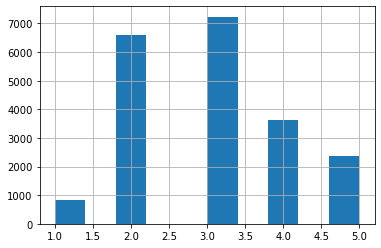

In [8]:
## Split the data to train and test set using train test split function.
#from sklearn.model_selection import train_test_split
# train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)
# print("The training set shape is :--", train_set.shape)
# print("The training set shape is :--", test_set.shape)

## stratified splitting.
## the median_income is a very important parameter in finding the pricing.
## so we need ensure that, when we do the training, the median_income data should be representative of various ranges.
## for that we will split the data of the median income to income category and then do the stratified sampling.

housing["income_cat"] = pd.cut(housing["median_income"],
                                  bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                                  labels = [1,2,3,4,5])
#housing.head()
housing["income_cat"].hist()

## do the stratified sampling using StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
splits = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
print(splits)
for train_index, test_index in splits.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
print(strat_train_set.shape)
print(strat_test_set.shape)

### Data Pipelines

In [39]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## defining the pipeline
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

from sklearn.compose import ColumnTransformer

housing_num = housing.drop("ocean_proximity", axis=1)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]


full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_num_transformed = num_pipeline.fit_transform(housing_num)
housing_prepared = full_pipeline.fit_transform(housing)

#housing_prepared

### Model Training

In [48]:
def display_scores(scores):
    print("Scores :--", scores)
    print("Mean :--", scores.mean())
    print("Standard Deviation :--", scores.std())

In [49]:
## linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg,
                            housing_prepared,
                            housing_labels,
                            scoring = "neg_mean_squared_error",
                            cv = 10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

68867.01067610044
Scores :-- [67621.36459192 67050.2893707  68159.77945126 74185.17069359
 68112.25073467 71610.00721757 65235.24278175 68160.85292722
 72191.44396288 68163.77349381]
Mean :-- 69049.01752253594
Standard Deviation :-- 2581.324004019164


In [50]:
## decision tree regression.
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_mse)

## evaluation using cross validation.
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg,
                            housing_prepared,
                            housing_labels,
                            scoring = "neg_mean_squared_error",
                            cv = 10)

tree_rmse_scores = np.sqrt(-scores)
#print(tree_rmse_scores)

## score of the decision tree regression model
display_scores(tree_rmse_scores)

0.0
Scores :-- [67849.89404252 68394.69851999 71198.64079576 70815.39376935
 68269.81880261 75170.66173305 67864.88682758 69714.89446158
 70438.63261499 69723.83001698]
Mean :-- 69944.13515844263
Standard Deviation :-- 2095.430218646422


In [51]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

## evaluation using cross validation.
from sklearn.model_selection import cross_val_score

scores = cross_val_score(forest_reg,
                            housing_prepared,
                            housing_labels,
                            scoring = "neg_mean_squared_error",
                            cv = 10)
forest_rmse_scores = np.sqrt(-scores)

display_scores(forest_rmse_scores)

Scores :-- [47926.12621858 45957.35798026 49208.86126657 50121.59714972
 48912.73351098 53089.35579472 48609.65714042 50481.84847991
 51629.07989048 49691.45734933]
Mean :-- 49562.80747809519
Standard Deviation :-- 1871.1979862484964


In [36]:
## support vector machine regression.

from sklearn.svm import SVR

svm_reg = SVR(kernel = "rbf")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)

scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
svm_rmse_scores = np.sqrt(-scores)

display_scores(svm_rmse_scores)

Scores :-- [111247.21317701 119396.43145067 116833.55574188 120315.38827564
 117473.40733098 122177.1766832  117508.05741988 121372.2608792
 120246.96168044 117895.41081887]
Mean :-- 118446.58634577622
Standard Deviation :-- 2944.102641153791


In [37]:
## support vector machine regression.

from sklearn.svm import SVR

svm_reg = SVR(kernel = "linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)

scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
svm_rmse_scores = np.sqrt(-scores)

display_scores(svm_rmse_scores)

Scores :-- [101985.4447837  108708.29000493 106606.08420994 109761.37429482
 107076.78301352 112271.69997278 106981.06203975 110927.07115344
 110327.4804773  108142.28149436]
Mean :-- 108278.75714445428
Standard Deviation :-- 2740.220321851756


### Fine Tune the Model.

+ GridSearchCV

+ RandomizedSearchCV

Grid Search CV on Random Forest Model.

In [73]:
## implrmrnting grid search. on Random Forest Model.
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators":[3,10,30], "max_features":[2,4,6,8]},
    {"bootstrap":[False], "n_estimators":[3,10], "max_features":[2,3,4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg,
                              param_grid,
                              cv = 5,
                              scoring = "neg_mean_squared_error",
                              return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'max_features': 8, 'n_estimators': 30}
RandomForestRegressor(max_features=8, n_estimators=30)
64075.216199488896 {'max_features': 2, 'n_estimators': 3}
56390.30770516369 {'max_features': 2, 'n_estimators': 10}
53795.34675829263 {'max_features': 2, 'n_estimators': 30}
61700.707020610054 {'max_features': 4, 'n_estimators': 3}
54252.984108555094 {'max_features': 4, 'n_estimators': 10}
52420.525614793376 {'max_features': 4, 'n_estimators': 30}
60139.63296209121 {'max_features': 6, 'n_estimators': 3}
53604.13427129526 {'max_features': 6, 'n_estimators': 10}
51852.9608089685 {'max_features': 6, 'n_estimators': 30}
59632.50567870918 {'max_features': 8, 'n_estimators': 3}
53198.257357191156 {'max_features': 8, 'n_estimators': 10}
50963.94162708029 {'max_features': 8, 'n_estimators': 30}
62131.03393740072 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
55711.318990770545 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
62220.859454018966 {'bootstrap': False, 'max_features

Randomized Search CV on the Random Forest Model.

In [69]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    "n_estimators" : randint(low = 1, high =200),
    "max_features" : randint(low = 1, high = 8)
}

forest_reg = RandomForestRegressor(random_state = 42)

random_search = RandomizedSearchCV(forest_reg,
                                      param_distributions=param_distribs,
                                      n_iter=10,
                                      cv=5,
                                      scoring = "neg_mean_squared_error",
                                      random_state = 42)

random_search.fit(housing_prepared, housing_labels)

cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50383.3165145688 {'max_features': 7, 'n_estimators': 180}
52786.84834507061 {'max_features': 5, 'n_estimators': 15}
51991.52608636662 {'max_features': 3, 'n_estimators': 72}
52293.40973372167 {'max_features': 5, 'n_estimators': 21}
50450.13139942525 {'max_features': 7, 'n_estimators': 122}
52028.16389639264 {'max_features': 3, 'n_estimators': 75}
51895.311110456896 {'max_features': 3, 'n_estimators': 88}
50983.4708457551 {'max_features': 5, 'n_estimators': 100}
51825.32498511003 {'max_features': 3, 'n_estimators': 150}
67248.17105862842 {'max_features': 5, 'n_estimators': 2}


Grid Search CV on Linear Regression Model

In [63]:
## implrmrnting grid search. on Random Forest Model.
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators":[3,10,30], "max_features":[2,4,6,8]},
    {"bootstrap":[False], "n_estimators":[3,10], "max_features":[2,3,4]}
]

lin_reg = LinearRegression()

grid_search = GridSearchCV(lin_reg,
                              param_grid,
                              cv = 5,
                              scoring = "neg_mean_squared_error",
                              return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

ValueError: Invalid parameter max_features for estimator LinearRegression(). Check the list of available parameters with `estimator.get_params().keys()`.

In [64]:
## implrmrnting grid search. on Random Forest Model.
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators":[3,10,30], "max_features":[2,4,6,8]},
    {"bootstrap":[False], "n_estimators":[3,10], "max_features":[2,3,4]}
]

tree_reg = DecisionTreeRegressor()

grid_search = GridSearchCV(tree_reg,
                              param_grid,
                              cv = 5,
                              scoring = "neg_mean_squared_error",
                              return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

ValueError: Invalid parameter n_estimators for estimator DecisionTreeRegressor(max_features=2). Check the list of available parameters with `estimator.get_params().keys()`.

### Evaluate the Model Using Test Set.

In [76]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

In [ ]:
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_